## Import data

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB


# Load data
B = pd.read_csv('data/B (power transfer factor of each bus to each line).csv', sep=';').values
P_max = pd.read_csv('data\Maximum production of generating units.csv').values.flatten()
P_min = pd.read_csv('data\Minimum production of generating units.csv').values.flatten()
min_downtime = pd.read_csv('data\Minimum down time of generating units.csv').values.flatten()
min_uptime = pd.read_csv('data\Minimum up time of generating units.csv').values.flatten()
C_g = pd.read_csv('data\Production cost of generating units.csv').values.flatten()
C_gs = pd.read_csv('data\Start-up cost of generating units.csv').values.flatten()
ramp = pd.read_csv('data\Ramping rate of generating units.csv').values.flatten()
F = pd.read_csv('data\Transmission capacity of lines.csv').values.flatten()

# Load wind data
W_cap = pd.read_csv('data/Capacity of wind farms.csv')
W1 = pd.read_csv('data\W1.csv', skiprows=3) 
W2 = pd.read_csv('data\W2.csv', skiprows=3)

# Scale wind data
W1 = np.array(W1.iloc[:,2]) * W_cap.values[0]
W2 = np.array(W2.iloc[:,2]) * W_cap.values[1]
W = np.vstack((W1, W2)).T

# Remove first row to fit with demand data
Wind = W[1:].T

# Load demand data
D = pd.read_csv('data\ConsumptionPerGridarea.csv', sep=';', decimal=',')
D = D.loc[D['GridCompany'].isin([131, 344, 16])]
D["HourDK"] = pd.to_datetime(D["HourDK"])
D = D.loc[D["HourDK"].dt.year == 2021]
D = D.pivot_table(index = "HourDK", columns = "GridCompany", values = "FlexSettledConsumption")

# Read and scale demand data
D_cap = pd.read_csv('data\Loads.csv')
D = (D/np.max(D, axis=0)) * D_cap.values.T
Demand = D.values.T




## Task 1: Understanding Unit Commitment and optimization model
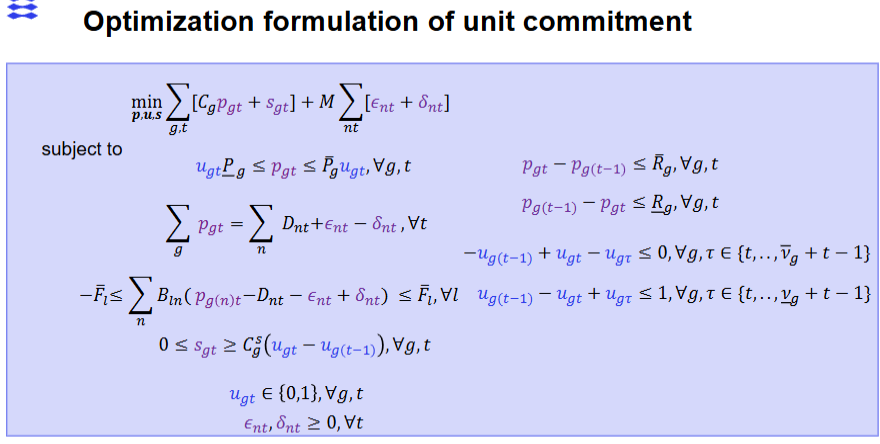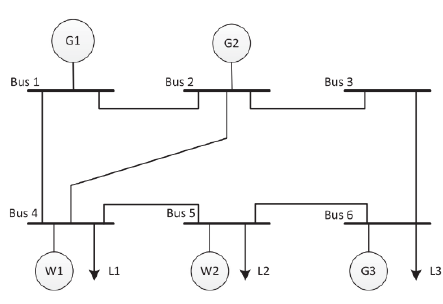

In [ ]:
G = len(P_max) # number of generators
L = len(F) # number of lines
N = B.shape[1] # number of nodes
G_n = [[0],[1],[],[],[],[2]]
W_n = [[ ],[],[],[0],[1],[]]
D_n = [[],[],[],[0],[1],[2]]
M = 1000 # Big M

def unit_commitment(Wind, Demand, initial_binary = None):
    #### Create model ####
    model = gp.Model()

    ### Parameters ###
    D, T = Demand.shape # number of time periods
    W = Wind.shape[0] # number of wind farms
    
    #### Decision variables ####
    # Production/bid in DA market
    p_g = model.addVars(G,T, lb = 0, vtype=GRB.CONTINUOUS, name="p_gt") # Power production in each generator in each time period
    p_w = model.addVars(W,T, vtype=GRB.CONTINUOUS, name="p_wt") # Power production in each wind farm in each time period
    u = model.addVars(G,T, vtype=GRB.BINARY, name="u_gt") # Binary variable for each generator in each time period
    s = model.addVars(G,T, lb = 0, vtype=GRB.CONTINUOUS, name="s_gt") # Start up cost for each generator in each time period

    # Slack variables
    delta   = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="delta") # Slack variable for each time period for each node
    epsilon = model.addVars(N,T, lb = 0, vtype=GRB.CONTINUOUS, name="epsilon") # Slack variable for each time period for each node

    #### Objective function ####
    # Assume no production cost for wind
    model.setObjective(gp.quicksum(C_g[g] * p_g[g,t] + s[g,t] for g in range(G) for t in range(T))
                    + M * gp.quicksum(delta[n,t] + epsilon[n,t] for n in range(N) for t in range(T)), GRB.MINIMIZE)

    ### Constraints ###
    # Minimum production
    model.addConstrs(u[g,t] * P_min[g] <= p_g[g,t] for g in range(G) for t in range(T))

    # Maximum production
    model.addConstrs(p_g[g,t] <= u[g,t] * P_max[g] for g in range(G) for t in range(T))

    # Wind upper bound
    model.addConstrs(p_w[w,t] <= Wind[w,t] for w in range(W) for t in range(T))

    # Power balance
    model.addConstrs((gp.quicksum(p_g[g,t] for g in range(G)) + gp.quicksum(p_w[w,t] for w in range(W))== 
                    gp.quicksum(Demand[n,t] + epsilon[n,t] - delta[n,t] for n in range(D)) for t in range(T)), "Power balance")

    # Line flow
    model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t])
                                   for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) >= - F[l] for t in range(T) for l in range(L)), "Line flow")
    model.addConstrs((gp.quicksum(B[l,n]*(p_g[g,t] + p_w[w,t] - D[d,t] - epsilon[n,t] + delta[n,t])
                                   for n in range(N) for g in G_n[n] for w in W_n[n] for d in D_n[n] ) <= F[l] for t in range(T) for l in range(L)), "Line flow")

    # Start-up cost
    model.addConstrs(s[g,t] >= C_gs[g] * (u[g,t] - u[g,t-1]) for g in range(G) for t in range(1,T))

    # Ramping constraint
    model.addConstrs(p_g[g,t] - p_g[g,t-1] <= ramp[g] for g in range(G) for t in range(1,T))
    model.addConstrs(p_g[g,t] - p_g[g,t-1] >= -ramp[g] for g in range(G) for t in range(1,T))

    # Minimum up time
    model.addConstrs(-u[g,t-1] + u[g,t] - u[g,tau] <= 0 for g in range(G) for t in range(1,T) for tau in range(t, min(min_uptime[g]+t-1, T-1)))

    # Minimum down time
    model.addConstrs(u[g,t-1] - u[g,t] + u[g,tau] <= 1 for g in range(G) for t in range(1,T) for tau in range(t, min(min_downtime[g]+t-1, T-1)))


    # Fix binary variables if given
    if initial_binary is not None:
        for g in range(G):
            for t in range(T):
                u[g,t].lb = initial_binary[g,t]
                u[g,t].ub = initial_binary[g,t]
        

    # Solve model
    model.setParam('OutputFlag', 0)
    model.optimize()

    if model.Status == GRB.INFEASIBLE:
            return None, None, None, None, None, None, None, True
    else:
        # Extract results
        p_g = np.array([[p_g[g,t].x for t in range(T)] for g in range(G)])
        p_w = np.array([[p_w[w,t].x for t in range(T)] for w in range(W)])
        u = np.array([[u[g,t].x for t in range(T)] for g in range(G)])
        s = np.array([[s[g,t].x for t in range(T)] for g in range(G)])
        delta = np.array([[delta[n,t].x for t in range(T)] for n in range(N)])
        epsilon = np.array([[epsilon[n,t].x for t in range(T)] for n in range(N)])
        obj = model.objVal

        return p_g, p_w, u, s, delta, epsilon, obj, False
 

Run the model for each day in a year and save information

In [168]:
days = Demand.shape[1]//24
df_res = pd.DataFrame(index = np.arange(days*24))
objectives = []

for d in range(days):
    p_g, p_w, u, s, delta, epsilon, obj, _ = unit_commitment(Wind[:,d*24:(d+1)*24], Demand[:,d*24:(d+1)*24])
    for g in range(p_g.shape[0]):
        df_res.loc[d*24:(d+1)*24-1, f"p_g_{g+1}"] = p_g[g].flatten()
        df_res.loc[d*24:(d+1)*24-1, f"u{g+1}"] = u[g].flatten()
        df_res.loc[d*24:(d+1)*24-1, f"s{g+1}"] = s[g].flatten()
    for w in range(p_w.shape[0]):
        df_res.loc[d*24:(d+1)*24-1, f"p_w_{w+1}"] = p_w[w].flatten()
    objectives.append(obj)


<Axes: title={'center': 'Production of generators'}, xlabel='Time [h]', ylabel='Production [MW]'>

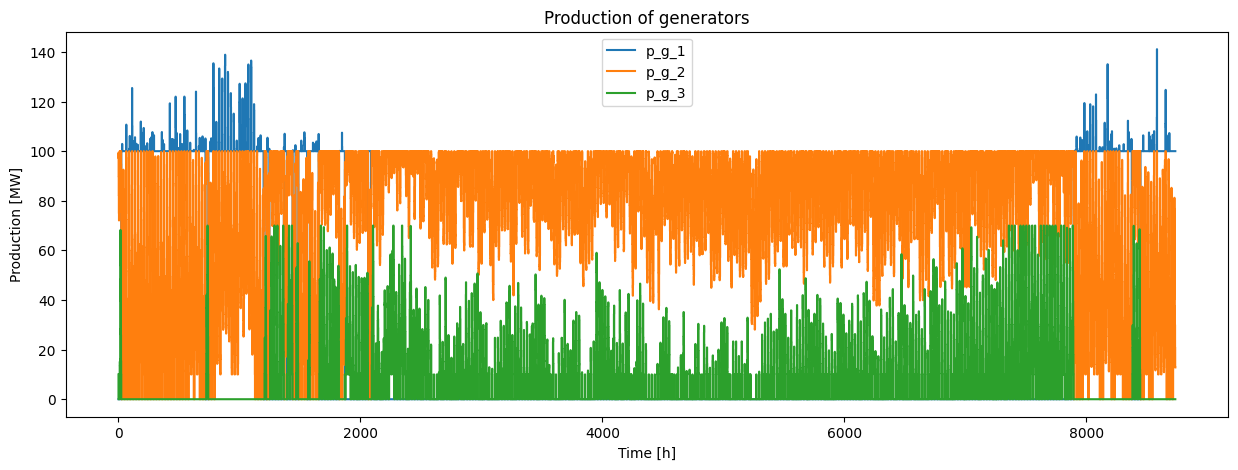

In [169]:
df_res[["p_g_1", "p_g_2", "p_g_3"]].plot(drawstyle="steps", figsize = (15,5), title = "Production of generators", ylabel = "Production [MW]", xlabel = "Time [h]")

<Axes: title={'center': 'Production of wind farms'}, xlabel='Time [h]', ylabel='Production [MW]'>

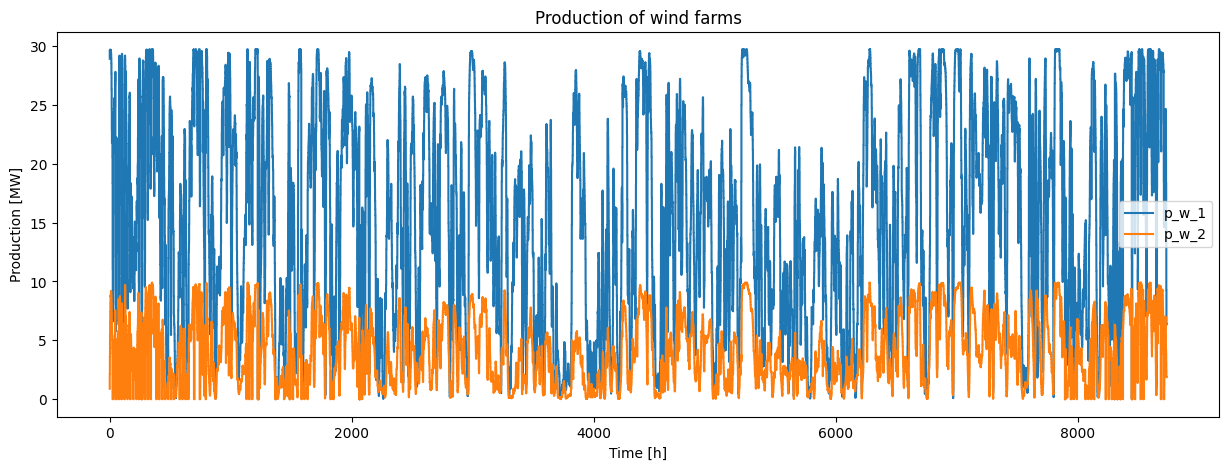

In [170]:
df_res.plot(y = ["p_w_1", "p_w_2"], drawstyle="steps", figsize = (15,5), title = "Production of wind farms", ylabel = "Production [MW]", xlabel = "Time [h]")

## Task 2: Data preperation

In [171]:
from sklearn.preprocessing import StandardScaler
x = np.vstack((Wind[:days*24,], Demand[:days*24,])).T
y = df_res[[f"u{g+1}" for g in range(G)]].values
x = x[:len(y)]

# Scale input data
scaler = StandardScaler()
x = scaler.fit_transform(x)


# Split into training, validation and test sets
train_test_fraction = 0.8
train_val_fraction = 0.8
train_test_split = int(np.floor(days * train_test_fraction))*24
train_val_split = int(np.floor(train_test_split * train_val_fraction))*24

x_train = x[:train_test_split]
x_train_train = x_train[:train_val_split]
x_val = x_train[train_val_split:]
x_test = x[train_test_split:]

y_train = y[:train_test_split]
y_train_train = y_train[:train_val_split]
y_val = y_train[train_val_split:]
y_test = y[train_test_split:]


## Task 3: Train classifiers

Train both linear and non-linear methods. Could be
- Linear
    - Logistic Regression
    - Linear Support Vector Machine (SVM)
- Non-linear
    - Decision Tree
    - k-Nearest Neighbors
    - Ensemble  methods
        - Random Forest


In [173]:
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

def predict_classes(classifiers):
        evaluations = {}
        for classifier in classifiers:
            # Get name of classifier and initialize predictions
            name = classifier["name"]
            y_pred = np.zeros(y_test.shape)
            for g in range(G):
                # Fit classifier and predict
                clf = classifier["classifier"](**classifier["params"])
                clf.fit(x_train, y_train[:,g])
                y_pred[:,g] = clf.predict(x_test)

            # Calculate metrics
            accuracy = np.sum(y_test == y_pred, axis=(0,1)) / (y_test.shape[0] * y_test.shape[1])
            precision = np.sum(y_test * y_pred, axis=(0,1)) / np.sum(y_pred, axis=(0,1))
            recall = np.sum(y_test * y_pred, axis=(0,1)) / np.sum(y_test, axis=(0,1))
            f1 = 2 * (precision * recall) / (precision + recall)
            conf_matrix = confusion_matrix(y_test.flatten(), y_pred.flatten())

            evaluations[name] = {"predictions": y_pred, "accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall, "confusion_matrix": conf_matrix}
        return evaluations



# Define classifiers 
classifiers = [{"classifier": DummyClassifier,        "name": "Baseline",            "params" : {"strategy": "most_frequent"}},
               {"classifier": LogisticRegression,     "name": "Logistic Regression", "params" : {}},
               {"classifier": SVC,                    "name": "SVC",                 "params" : {"kernel": "linear"}},
               {"classifier": DecisionTreeClassifier, "name": "Decision Tree",       "params" : {}},
               {"classifier": KNeighborsClassifier,   "name": "KNN",                 "params" : {"n_neighbors" : 10}},
               {"classifier": RandomForestClassifier, "name": "Random Forest",       "params" : {}}
               ]

evaluations = predict_classes(classifiers)


## Task 4: Evaluate models

In [174]:
df = pd.DataFrame(evaluations)
df

,Baseline,Logistic Regression,SVC,Decision Tree,KNN,Random Forest
predictions,"[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ...","[[0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, ..."
accuracy,0.71328,0.739916,0.746195,0.785769,0.807268,0.810502
f1,0.68267,0.763781,0.774434,0.812583,0.828798,0.833667
precision,0.925228,0.792115,0.785053,0.810694,0.839726,0.834504
recall,0.540874,0.737404,0.764097,0.814481,0.818151,0.832833
confusion_matrix,"[[2128, 131], [1376, 1621]]","[[1679, 580], [787, 2210]]","[[1632, 627], [707, 2290]]","[[1689, 570], [556, 2441]]","[[1791, 468], [545, 2452]]","[[1764, 495], [501, 2496]]"


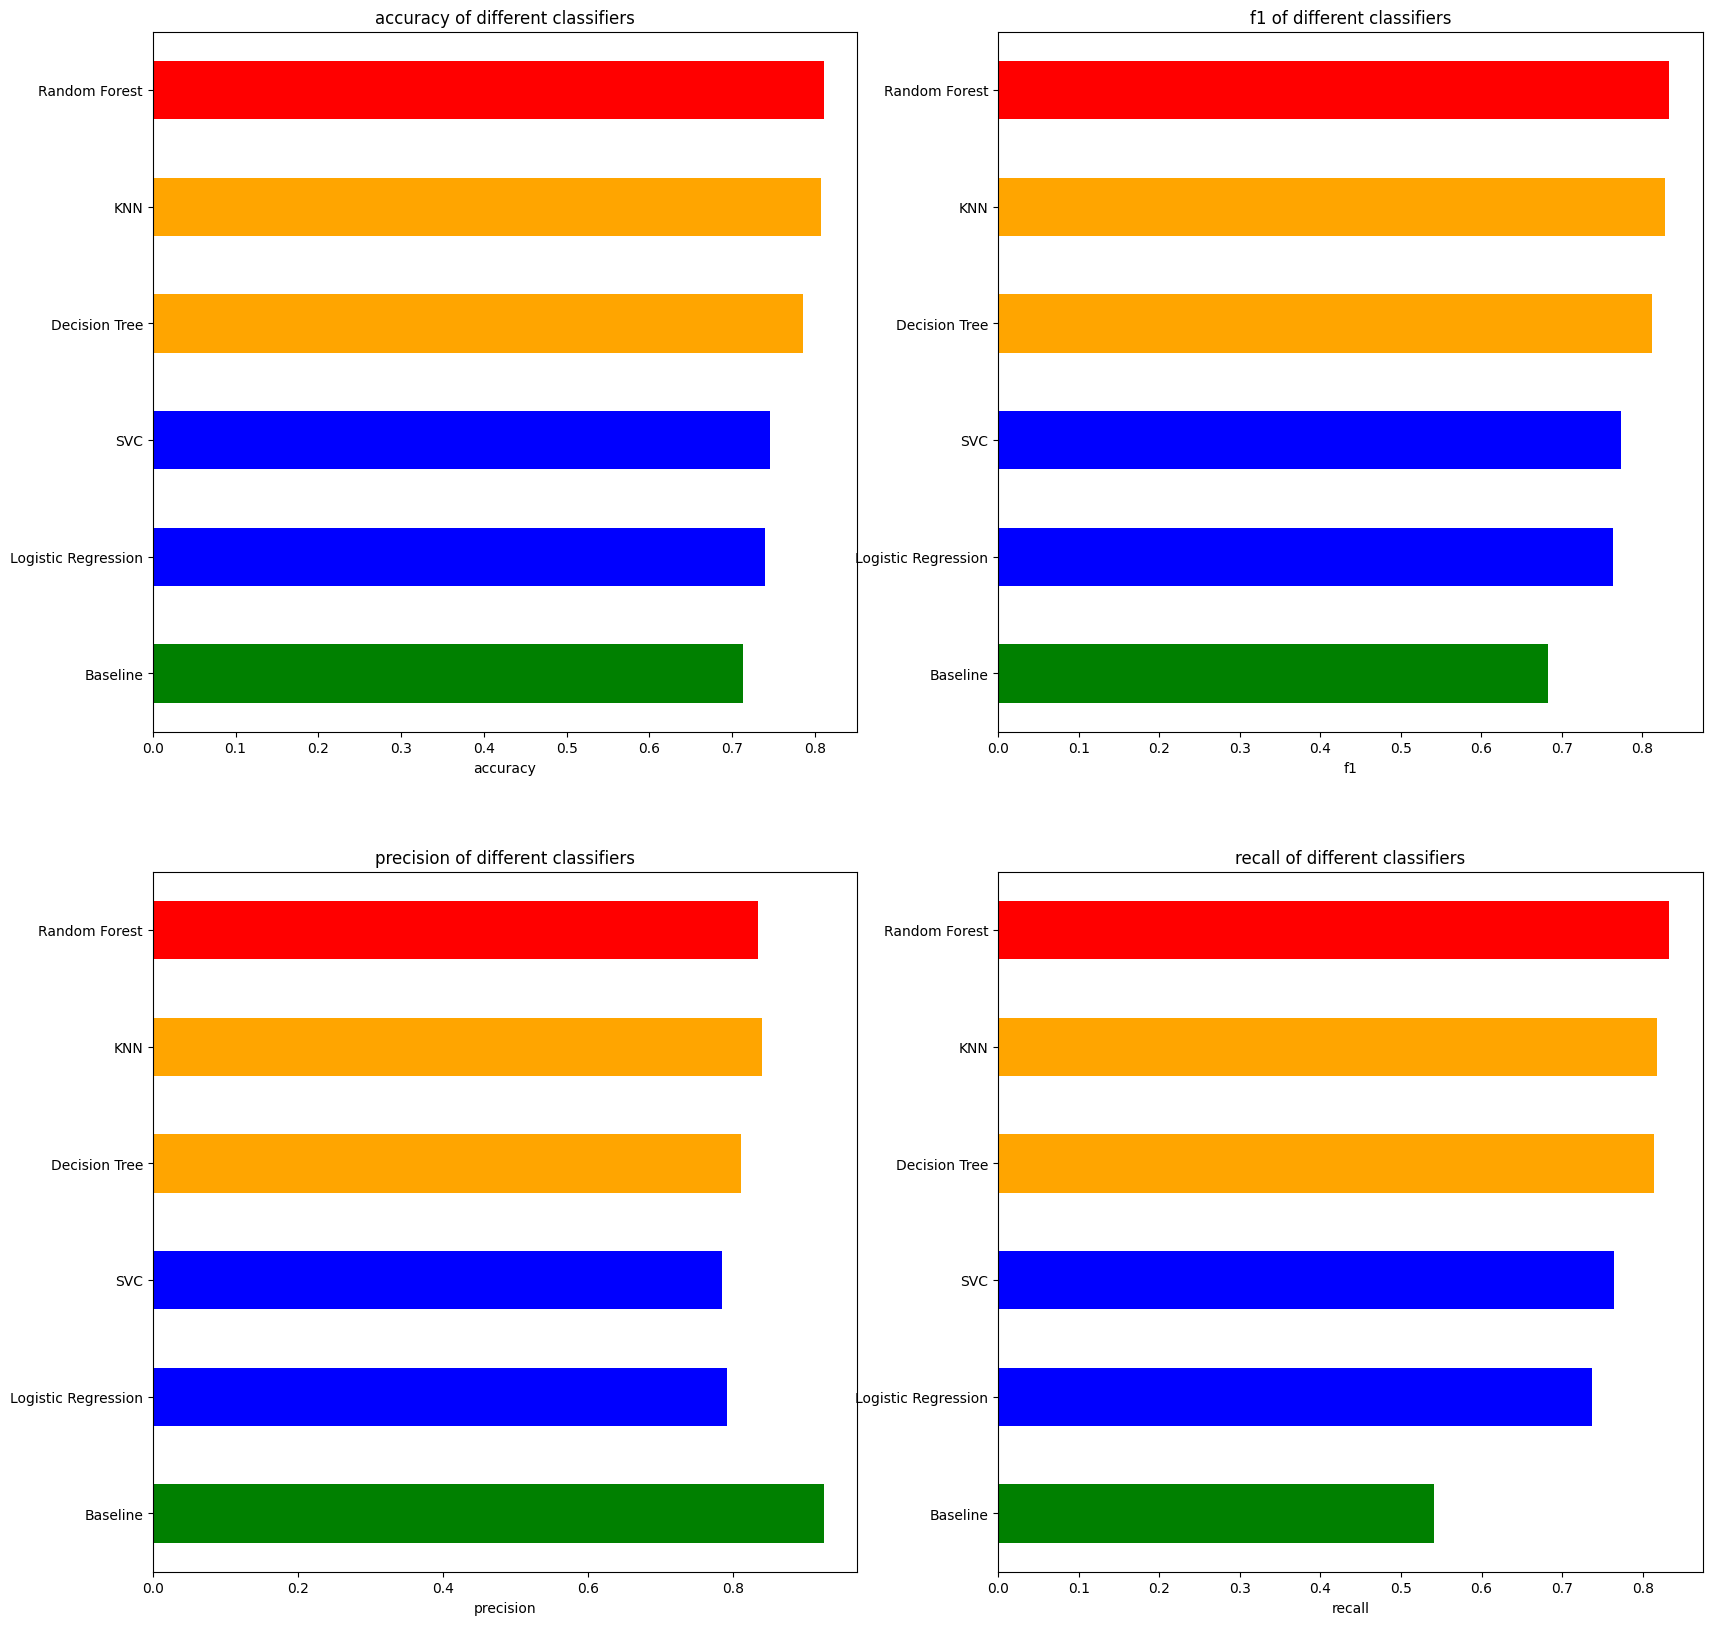

In [175]:
colors = ["green", "blue", "blue", "orange", "orange", "red"]

fig, axs = plt.subplots(2, 2, figsize=(20,20))

metrics = ["accuracy", "f1", "precision", "recall"]

for i, metric in enumerate(metrics):
    df.loc[metric,:].plot(kind="barh", ax=axs[i//2, i%2], color=colors)
    axs[i//2, i%2].set_xlabel(metric)
    axs[i//2, i%2].set_title(f"{metric} of different classifiers")
plt.show()


One thing is how often the models correctly predicts the binary variables, another is how big an impact the wrong prediction have. What would happen if we fixed the binaries to the predicted values and ran the optimizer again?

In [ ]:
# Reverse scaling of input data
test_inv_scaled = scaler.inverse_transform(x_test)
wind, demand = test_inv_scaled[:,0:2].T, test_inv_scaled[:,2:4].T
days = int(len(y_test)/24)

# Check infeasibility for each classifier
for clf in df.columns:
    infeasible_days = 0
    for day in range(days):
        _, _, _, _, _, _, _, infeasible = unit_commitment(wind[:,day*24:(day+1)*24], demand[:,day*24:(day+1)*24], df.loc["predictions",clf][day*24:(day+1)*24, :].T)
        infeasible_days += infeasible

    print(clf + f" Model is infeasible for %.2f %% of tested days" % (infeasible_days/days*100))

Baseline Model is infeasible for 0.00 % of tested days
Logistic Regression Model is infeasible for 79.45 % of tested days
SVC Model is infeasible for 93.15 % of tested days
Decision Tree Model is infeasible for 91.78 % of tested days
KNN Model is infeasible for 95.89 % of tested days
Random Forest Model is infeasible for 95.89 % of tested days


We see that even though the models achieve decent metrics, most days would be infeasible if we were to use the predictions as input to our model. Only the baseline model appears to be feasible. This is due to it always has G2 turned on and the others turned off, therefore never violating the up/down time. However, running the optimization model with the predicted binary variables as fixed variables in the model, we find a much higher cost and value of delta, meaning a more expensive system and a need for load shedding due to lack of supply

In [177]:
# Calculate total cost of Baseline model and slack variables
objs = 0
deltas = 0
epsilons = 0
p_g_cls = np.zeros((G, days*24))
for day in range(days):
        p_g, _, _, _, delta, epsilon, obj, _ = unit_commitment(wind[:,day*24:(day+1)*24], demand[:,day*24:(day+1)*24], df.loc["predictions","Baseline"][day*24:(day+1)*24, :].T)
        objs += obj
        deltas += np.sum(delta)
        epsilons += np.sum(epsilon)
        p_g_cls[:,day*24:(day+1)*24] = p_g

print(f"Total cost of Baseline model: {objs}")
print(f"Total slack variable delta: {deltas}")
print(f"Total slack variable epsilon: {epsilons}")

Total cost of Baseline model: 3055470.628184661
Total slack variable delta: 1223.7392034635666
Total slack variable epsilon: 0.0


In [178]:
# Calculate total cost of optimal model and slack variables
objs = 0
deltas = 0
epsilons = 0
p_g_opt = np.zeros((G,days*24))
for day in range(days):
        p_g, _, _, _, delta, epsilon, obj, _ = unit_commitment(wind[:,day*24:(day+1)*24], demand[:,day*24:(day+1)*24])
        objs += obj
        deltas += np.sum(delta)
        epsilons += np.sum(epsilon)
        p_g_opt[:,day*24:(day+1)*24] = p_g

print(f"Total cost of opt model: {objs}")
print(f"Total slack variable delta: {deltas}")
print(f"Total slack variable epsilon: {epsilons}")


Total cost of opt model: 1869049.8263246967
Total slack variable delta: 0.31278490391765423
Total slack variable epsilon: 0.0
